# CO2SYS pH Temperature Sensitivity

---

Using CO2SYS (python implementation of it) to compute the sensitivity of pH to temperature in the CalCS LME. Need to fix DIC, ALK, etc. to find the underlying relationship.

ACtual package is `cbsyst`: https://github.com/oscarbranson/cbsyst

In [1]:
import cbsyst as cb
from scipy.stats import linregress

import numpy as np
import pandas as pd
import xarray as xr

import esmtools as et
import climpred as cp
import caldecpred as project

import matplotlib.pyplot as plt 
%matplotlib inline
import proplot as plot
plot.nbsetup()

Based on Nikki's code, I should need to get the mean Alk, DIC, Salinity from FOSI for the CalCS LME to compute temperature sensitivity to pH. I can do more advanced things after this (sensitivity over time slices, grid cells, etc.)

**Default unit is $\mu$mol/L**

**NOTE: This package doesn't have phosphorous or silicate to compute phosphoric acid/silicic acids... is this a problem?**

### California Current Averages

DIC: 1998.3 mmol/m3 ($\mu$mol)

Alk: 2247.5 meq/m3 ($\mu$mol)

Salinity: 33.5 PSU

---

First attempt is to fix DIC and Alk and then vary the temperature to get various pH outputs. Then you regress the resulting pH onto the range of temperatures.

```python
cb.Csys(DIC=const, TA=const, T_in=variable)
```

In [2]:
def load_processed_FOSI(var, annual_means=True, area_weight=True):
    """
    I used NCO's to process the raw 3D output for DIC/ALK from Steve's FOSI reconstruction.
    
    ncks -v VAR -d z_t,0 in.nc out.nc
    """
    filepath = '/glade/scratch/rbrady/CalCS_decadal_prediction/FOSI_output/'
    ds = xr.open_dataset(f'{filepath}/{var}surf.194801-201712.nc',
                         decode_times=False)
    ds = ds.squeeze()[var]
    ds['time'] = pd.date_range('1948-01', '2018-01', freq='M')
    if annual_means:
        ds = ds.groupby('time.year').mean('time').rename({'year': 'time'})
    # Mask LME
    mask = project.IO.load_mask()
    ds = ds.where(mask==3)
    # Area-weight
    if area_weight:
        ds = et.stats.xr_area_weight(ds, area_coord='TAREA')
    ds.name = var
    return ds

This tells us the area-weighted annual mean over 1948-2017 for the CalCS LME. I want to start simply here, then move on to gridcell averages, etc.

In [3]:
DIC = load_processed_FOSI('DIC')
ALK = load_processed_FOSI('ALK')
SALT = load_processed_FOSI('SALT')
SST = project.IO.load_FOSI('SST', dple_time=False, annual=False)
# Mask LME
mask = project.IO.load_mask()
SST = SST.where(mask==3)
SST.name = 'SST'

/glade/u/home/rbrady/miniconda3/envs/python3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Summing over nlat
Summing over nlon


/glade/u/home/rbrady/miniconda3/envs/python3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Summing over nlat
Summing over nlon


/glade/u/home/rbrady/miniconda3/envs/python3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Summing over nlat
Summing over nlon


In [4]:
PH = project.IO.load_FOSI('PH', dple_time=False, annual=False)
mask = project.IO.load_mask()
PH = PH.where(mask==3)
PH.name = 'PH'

In [8]:
print(f'Average Surface Salinity: {np.round(SALT.mean().values, 1)}')
print(f'Average Surface DIC: {np.round(DIC.mean().values, 1)}')
print(f'Average Surface Alkalinity: {np.round(ALK.mean().values, 1)}')
print(f'Average SST: {np.round(SST.mean().values, 1)}')
print(f'Average pH: {np.round(PH.mean().values, 2)}')

Average Surface Salinity: 33.5
Average Surface DIC: 1998.3
Average Surface Alkalinity: 2247.5
Average SST: 17.5
Average pH: 8.09000015258789


Can put in T range that is realistic for the CalCS. No area-weighting or annual means so we can get the full range of the system.

In [9]:
print(f'Minimum SST: {np.round(SST.min().values, 1)}')
print(f'Maximum SST: {np.round(SST.max().values, 1)}')

Minimum SST: 7.1
Maximum SST: 30.7


## What is the variability in carbonate ion from detrended pH variability?

---

Can we prove that the ~0.01 pH variability is important?

In [10]:
# area-weight
PH = et.stats.xr_area_weight(PH, area_coord='TAREA')

Summing over nlat
Summing over nlon


In [11]:
# detrend
PH = et.stats.xr_rm_poly(PH, order=2, dim='initialization')

In [12]:
# deseasonalize
clim = PH.groupby('initialization.month').mean()
PH = PH.groupby('initialization.month') - clim

In [13]:
meanCO3 = cb.Csys(DIC=1998.3, TA=2247.5, S_in=33.5, T_in=17.5, pHtot=8.086).CO3

In [14]:
(cb.Csys(DIC=1998.3, TA=2247.5, S_in=33.5, T_in=17.5, pHtot=8.076).CO3 - meanCO3)/meanCO3 * 100

array([-1.84688824])

In [15]:
(cb.Csys(DIC=1998.3, TA=2247.5, S_in=33.5, T_in=17.5, pHtot=8.096).CO3 - meanCO3)/meanCO3 * 100

array([1.87323732])

## Compute T-sensitivity for fixed annual area-weighted mean

---

dPH/dT = -0.0153

In [16]:
epsilon=1e-14 # for np.arange
# actual range of CalCS SST to compute sensitivity over.
SST_range = np.arange(7, 31+epsilon, 0.1)
pHtot = cb.Csys(DIC=1998.3, TA=2247.5, S_in=33.5, T_in=SST_range)['pHtot']

In [17]:
m, b, r, p, err = linregress(SST_range, pHtot)
vals = m*SST_range + b

In [18]:
np.round(m, 4)

-0.0153

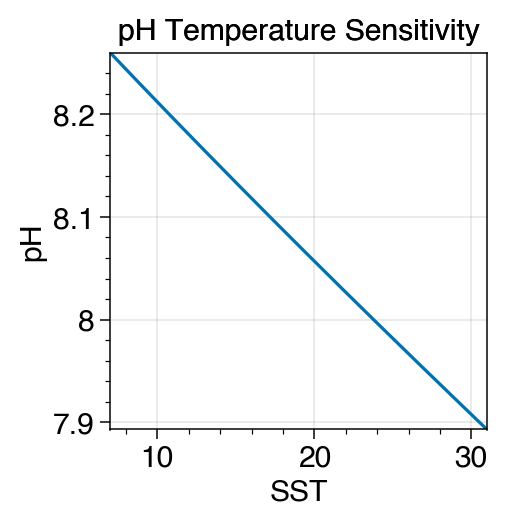

In [19]:
plot.nbsetup()
plot.rc.small = 12
plot.rc.large = 12
plot.rc['figure.facecolor'] = 'w'
f, ax = plot.subplots()

ax.plot(SST_range, pHtot)
ax.format(xlabel='SST', ylabel='pH',
          title='pH Temperature Sensitivity')

## Compute T-sensitivity over range of DIC

---

Total alkalinity and salinity stay generally constant over the time period of interest, but DIC has a large trend. Will now compute dPH/dT over a range of DIC's (5-year means) to see how much it changes.

In [20]:
DIC_in = []
for i in np.arange(0, 66, 5):
    DICmean = np.asarray(DIC.isel(time=slice(i, i+5)).mean())
    DIC_in.append(DICmean)

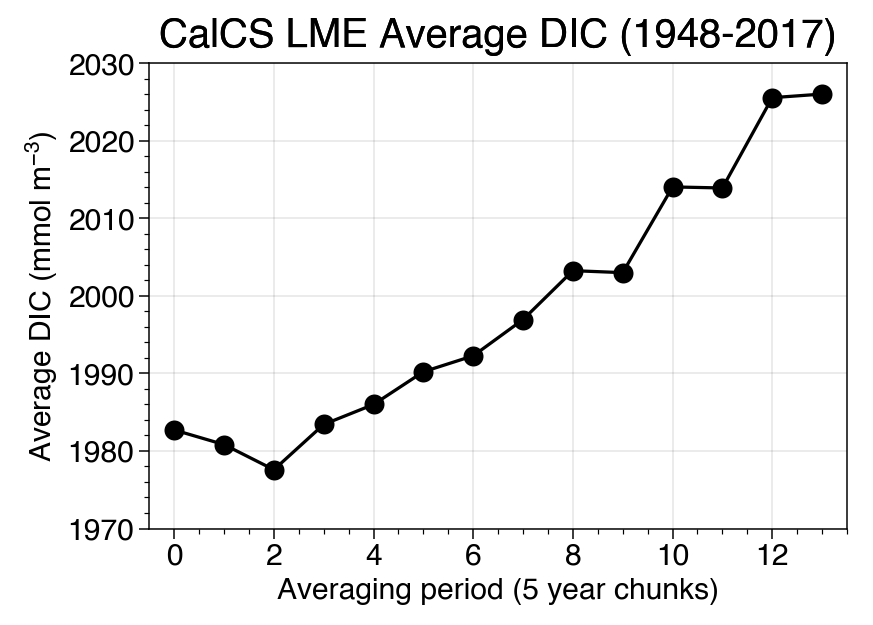

In [21]:
f, ax = plot.subplots(axwidth=4, aspect=1.5)
plot.rc.small = 12
plot.rc.large = 16

ax.plot(DIC_in, 'ok-', markersize=8)
ax.format(ylabel='Average DIC (mmol m$^{-3}$)',
          xlabel='Averaging period (5 year chunks)',
          title='CalCS LME Average DIC (1948-2017)',
          ylim=[1970, 2030],
          xlim=[-0.5, 13.5])

Now we compute over the same CalCS SST range, and find a slope for each DIC value.

In [22]:
sensitivities = []
for DIC in DIC_in:
    pHtot = cb.Csys(DIC=DIC, TA=2247.5, S_in=33.5, T_in=SST_range)['pHtot']
    m, *_ = linregress(SST_range, pHtot)
    sensitivities.append(m)

In [23]:
print('sensitivities:')
sensitivities

sensitivities:


[-0.01531716200987775,
 -0.015323219523162445,
 -0.01533348057324804,
 -0.015314852335119112,
 -0.015306454273930304,
 -0.015292413575351263,
 -0.01528545415164336,
 -0.015269287694782889,
 -0.015246751944163438,
 -0.01524768526521716,
 -0.015205972751391282,
 -0.015206506247827186,
 -0.015159093053680689,
 -0.015157130193516982]

In [24]:
pct_range = ((sensitivities[0] - sensitivities[-1])/np.mean(sensitivities))*100
print(f'dPH/dT ranges by {np.round(pct_range, 2)}% over DIC span of CalCS')

dPH/dT ranges by 1.05% over DIC span of CalCS


## Compute T-sensitivity over different months

---

Do seasonal variations in DIC/Alk/SALT matter enough to dictate varying dPH/dT over the different months?

In [25]:
DIC = load_processed_FOSI('DIC', annual_means=False).groupby('time.month').mean('time')
ALK = load_processed_FOSI('ALK', annual_means=False).groupby('time.month').mean('time')
SALT = load_processed_FOSI('SALT', annual_means=False).groupby('time.month').mean('time')

Summing over nlat
Summing over nlon
Summing over nlat
Summing over nlon
Summing over nlat
Summing over nlon


In [26]:
monthlySensitivity = []
# iterate through months
for i in np.arange(0, 12):
    dic_in = DIC.isel(month=i).values
    alk_in = ALK.isel(month=i).values
    salt_in = SALT.isel(month=i).values
    pHtot = cb.Csys(DIC=dic_in, TA=alk_in, S_in=salt_in, T_in=SST_range)['pHtot']
    m, *_ = linregress(SST_range, pHtot)
    monthlySensitivity.append(m)

In [27]:
maxSens, minSens = np.max(monthlySensitivity), np.min(monthlySensitivity)
meanSens = np.mean(monthlySensitivity)

pct_range = ((maxSens - minSens)/meanSens)*100
print(f'dPH/dT ranges by {np.round(np.abs(pct_range), 2)}% over DIC span of CalCS')

dPH/dT ranges by 0.39% over DIC span of CalCS


In [28]:
print('Monthly Sensitivities:')
monthlySensitivity

Monthly Sensitivities:


[-0.01523966795842561,
 -0.015233447528868894,
 -0.015237327054943265,
 -0.015247624467097688,
 -0.015258133907931444,
 -0.015267619705373651,
 -0.015277378167176675,
 -0.015286363145436521,
 -0.015293218608997218,
 -0.01529214875034557,
 -0.015279453187183852,
 -0.015257137365932183]

## Compute T-sensitivity over each grid cell

---

Now we'll take the annual means over each grid cell to input into the solver (since we know monthly means and time slices don't really affect the sensitivity)

In [29]:
coords = xr.open_dataset('/glade/work/rbrady/esmask/masks/POP/POP.x1.coords.nc')
DIC = load_processed_FOSI('DIC', area_weight=False).mean('time')
DIC.coords['TLONG'] = coords['TLONG']
ALK = load_processed_FOSI('ALK', area_weight=False).mean('time')
ALK.coords['TLONG'] = coords['TLONG']
SALT = load_processed_FOSI('SALT', area_weight=False).mean('time')
SALT.coords['TLONG'] = coords['TLONG']

/glade/u/home/rbrady/miniconda3/envs/python3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/rbrady/miniconda3/envs/python3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/rbrady/miniconda3/envs/python3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/rbrady/miniconda3/envs/python3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [30]:
def plot_LME_mean(ax, dat, vmin=None, vmax=None, **kwargs):
    """Quick plot of the mean for that variable."""
    p = project.viz.plot_CalCS_map(ax, dat, cbar_on=False,
                                   vmin=vmin, vmax=vmax,
                                   **kwargs)
    cbar = plt.colorbar(p, orientation='horizontal', ax=ax,
                      pad=0.05)
    return p, cbar

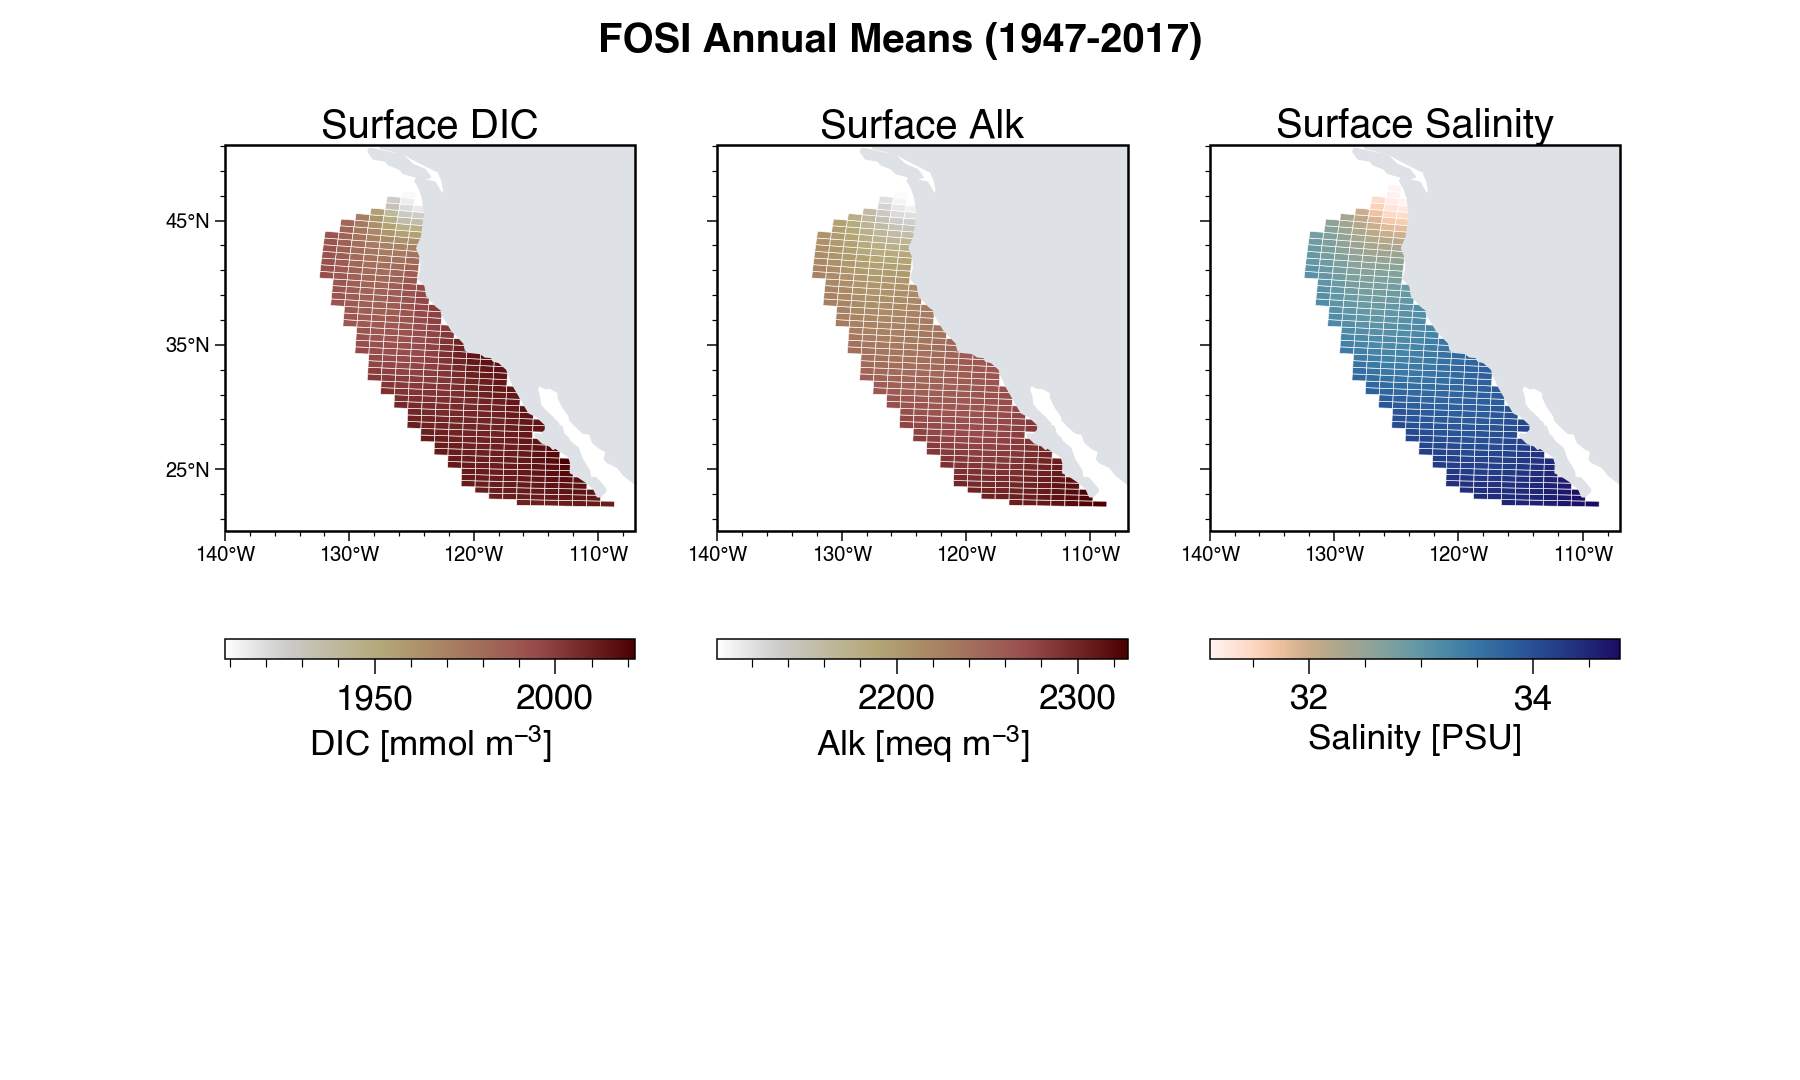

In [31]:
import cartopy.crs as ccrs
f, ax = plt.subplots(figsize=(10,6),
                     ncols=3, 
                     subplot_kw=dict(projection=ccrs.PlateCarree()),
                     sharey=True)

_, cbar = plot_LME_mean(ax[0], DIC, cmap='Bilbao')
cbar.set_label('DIC [mmol m$^{-3}$]')
ax[0].set_title('Surface DIC')

_, cbar = plot_LME_mean(ax[1], ALK, cmap='Bilbao')
cbar.set_label('Alk [meq m$^{-3}$]')
ax[1].set_title('Surface Alk')

_, cbar = plot_LME_mean(ax[2], SALT, cmap='Lapaz')
cbar.set_label('Salinity [PSU]')
ax[2].set_title('Surface Salinity')

f.suptitle('FOSI Annual Means (1947-2017)')
f.subplots_adjust(top=2.1)

In [32]:
"""
# allow grids for cbsyst
dims = DIC.shape
dic_in = DIC.values.flatten()
alk_in = ALK.values.flatten()
salt_in = SALT.values.flatten()

# have to fill with something 
# to make concat easy.
pH_grid = xr.DataArray(np.zeros_like(DIC),
                       dims=DIC.dims,
                       coords=DIC.coords)
for temperature in SST_range:
    pHtot = cb.Csys(DIC=dic_in, TA=alk_in, S_in=salt_in,
                    T_in=temperature)['pHtot'] \
              .reshape(dims)
    pHtot = xr.DataArray(pHtot, dims=DIC.dims, coords=DIC.coords)
    pH_grid = xr.concat([pH_grid, pHtot], dim='temperature')
# remove dummy slice
pH_grid = pH_grid.isel(temperature=slice(1, pH_grid.temperature.size))
pH_grid.coords['temperature'] = SST_range

m, *_ = et.stats.xr_linregress(pH_grid, dim='temperature', compact=False)
m = m.where(m!=0, np.nan)
"""
filepath = '/glade/scratch/rbrady/CalCS_decadal_prediction/dPH_dT/'
pH_grid = xr.open_dataset(f'{filepath}/pH.gridded.CO2SYS.bytemperature.nc')
m = xr.open_dataset(f'{filepath}/dPH_dT.by.gridcell.nc')

Text(0.5, 1.0, 'pH Sensitivity to T by grid cell')

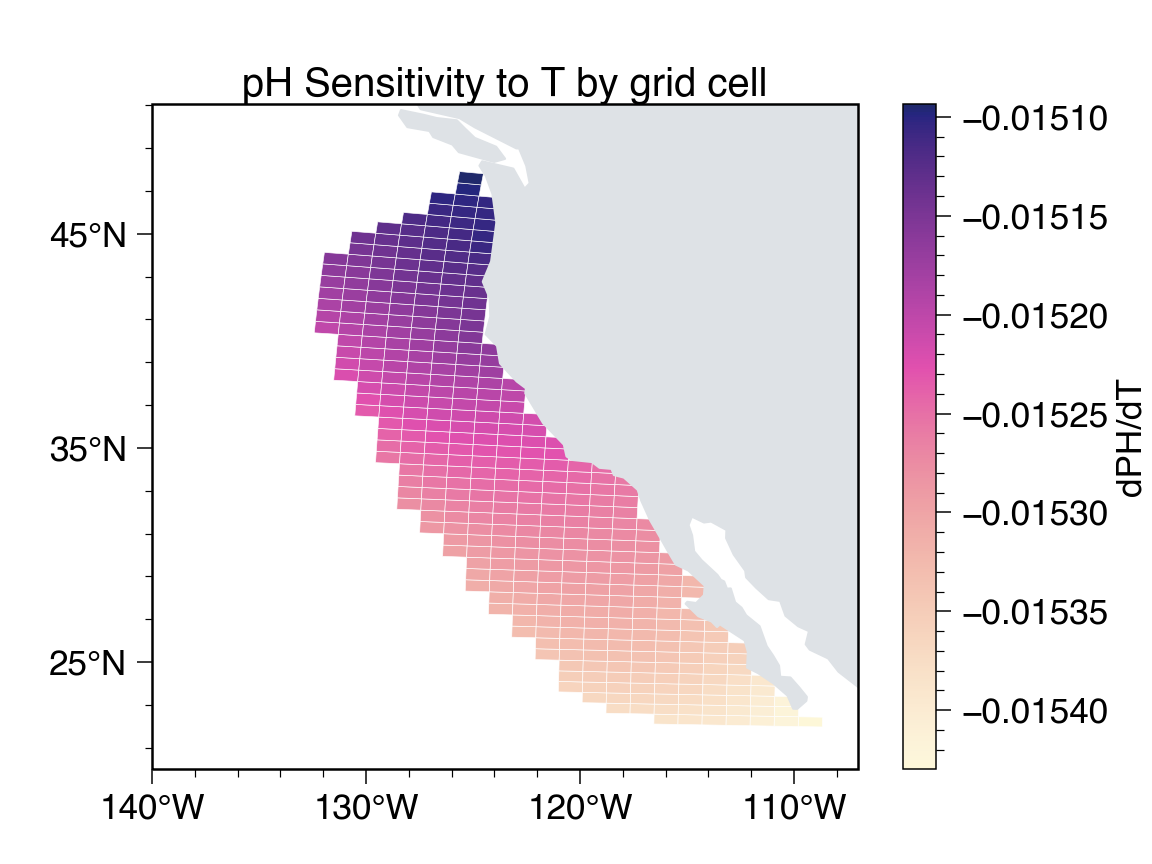

In [33]:
plot.rc.small = 14
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))

p, cbar = project.viz.plot_CalCS_map(ax, m['slope'])
cbar.set_label('dPH/dT')
ax.set_title('pH Sensitivity to T by grid cell')

In [34]:
pct = (m.max() - m.min())/m.mean() * 100
np.abs(pct)

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    z_t      float32 500.0
Data variables:
    slope    float64 2.206